In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 27
random.seed(SEED)
np.random.seed(SEED)


In [10]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

cols_to_use = ['State','FDID','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)



# SVI not Currently used 
#svi2016_path = data_path.parent/ 'Master Project Data'  / 'SVI Tract Data.csv'
#svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

#svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

#svi2016 = pd.read_csv(svi2016_path,
#                     index_col=0,
#                     dtype = svi_col_dtypes)



ACS_path = data_path  / 'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                index_col = 1)
            


In [11]:
#NFIRS Munging

nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')


In [12]:
nfirs['GEOID'] =  nfirs['GEOID'].str.strip('.')
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2].str.zfill(12))
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs['GEOID'].str.len().value_counts()
nfirs.set_index('GEOID',inplace = True)


In [13]:
# ACS Munging
ACS['GEOID'] = ACS['GEOID'].str[2:]   
ACS.set_index(['GEOID'],inplace = True)

In [14]:

if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)



tot_pop = ACS[['tot_population']]
# Drop all total columns in ACS to keep all percentages 
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1 : 
        ACS.drop(col,'columns', inplace = True)
ACS =ACS.iloc[:,3:]


In [15]:
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)
ACS.isna().sum().sum()

0

In [23]:
## Adjust total fires per year by the population counts

fires =  pd.crosstab(nfirs.index,nfirs['year'])

fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)
fires.index.rename('GEOID',inplace = True)
# drop rows with no population count
fires = fires[fires['tot_population'] != 0 ] 
# population adjustment
fires.loc[:,'2009':'2016'] = fires.loc[:,'2009':'2016'].div(fires['tot_population'], axis = 'index') * 1000

fires = fires.loc[:,:'2016']


In [24]:
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

,2009,2010,2011,2012,2013,2014,2015,2016
count,194893.000000,194893.000000,194893.000000,194893.000000,194893.000000,194893.000000,194893.000000,194893.000000
mean,0.878821,0.929452,0.834260,0.866746,0.899590,1.013351,0.998429,1.037384
std,2.746343,2.877914,2.745082,2.948369,2.420334,2.401616,2.582917,7.218416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.273373,0.000000,0.000000,0.249314,0.464684,0.455373,0.434594
75%,1.137656,1.204094,1.111111,1.120448,1.169591,1.304206,1.290323,1.296176
85%,1.743173,1.841621,1.703578,1.707942,1.782531,1.972387,1.934236,1.972387
90%,2.317497,2.425850,2.247191,2.262443,2.352941,2.587188,2.541296,2.577320
95%,3.493283,3.612717,3.316750,3.389831,3.484321,3.824092,3.738318,3.787879
99%,7.331563,7.575758,6.833713,7.317252,7.423098,8.009276,7.795274,7.819559


In [25]:
def plotFires(df):

    #g = sns.FacetGrid(nfirs,col = 'year' , row = 'GEOID', aspect=.25)
    #g.map(sns.distplot())
    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)



    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])
        #plt.hist(df[case[1]])





In [26]:
top10 = fires > fires.quantile(.9)


In [27]:
top10.sum() / top10.shape[0] * 100

2009     9.999333
2010    10.000359
2011     9.993176
2012     9.998820
2013     9.998820
2014    10.000359
2015     9.995228
2016     9.987532
dtype: float64

In [28]:
high2009 = fires[ fires['2009'] > 7] 

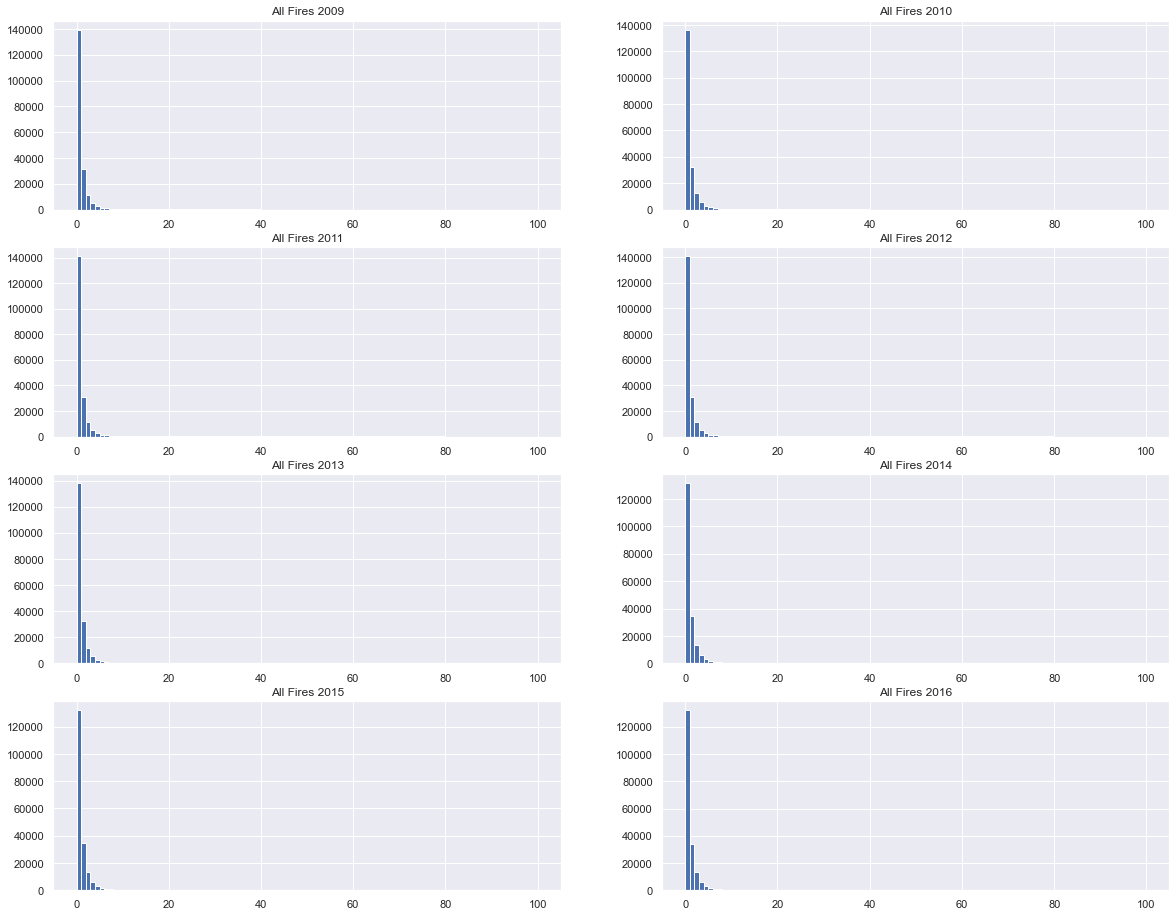

In [29]:
plotFires(fires)

In [31]:
# What percentage of rows has 1 NA
    #  How many rows have 1 NA    / Total # of rows * 100 
sum(ACS.isna().sum(axis = 1) > 0) / ACS.shape[0]  * 100


0.0

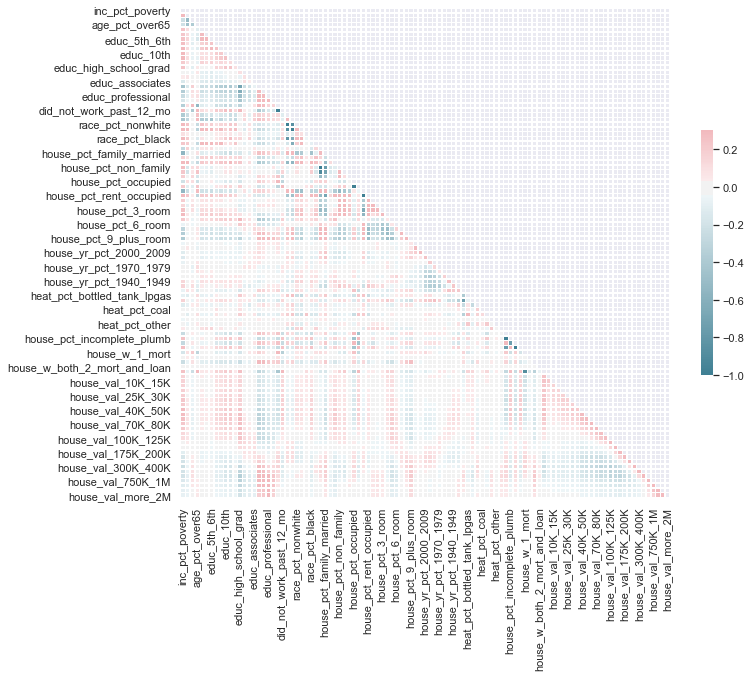

In [44]:
# Find correlated features in ACS dataset 

corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [32]:
def resample_df(X,y,upsample=True ,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    
    
    if upsample:      

        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0],
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      df_major_resampled.shape[0]))


    
    
    print(combined.columns)
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1 )
    return X_out , y_out

In [40]:
def train_model(fires,top10,ACS = pd.DataFrame() ,nyears = 4,modeltype='LogisticRegression',resample = False, seed = SEED):
    from scipy.stats import zscore
    
    years = top10.columns
        
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000
                                  )
    
    elif modeltype =='SVM':
        from sklearn.svm import SVC
        model = SVC(
            gamma='auto',
            kernel='linear',
            class_weight = 'balanced',
            random_state=SEED)

    elif modeltype =='SVM2':
        from sklearn.svm import LinearSVC
        model = LinearSVC(penalty='l1', 
                          loss='squared_hinge', 
                          dual=False, 
                          tol=0.0001, 
                          C=1, 
                          multi_class='ovr', 
                          fit_intercept=True, 
                          intercept_scaling=1, 
                          class_weight='balanced', 
                          verbose=0, 
                          random_state=SEED, 
                          max_iter=500) 
        
    elif modeltype =='Bagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)

    elif modeltype == 'NN':
        model = MLPClassifier(hidden_layer_sizes=(fires.shape[1],fires.shape[1]//2 ),
                              activation='relu', 
                              solver='adam',
                              max_iter=200)
    

        
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
            
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        #md = np.median(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        #X['Median'] =md
        X['Max']  = mx
       # X = X[['Max','Median','Sum']]
        y = top10.iloc[:,y_pointer]
    
    # merge in ACS Data into X 
        if not ACS.empty:
            X = X.merge(ACS, how ='left',left_index = True, right_index = True)
            X = X.dropna()
            y = y.filter(X.index)
    
        
        if resample:
            X,y = resample_df(X,y)
           
       # X = X.apply(zscore,0)
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        scaler.transform(X_test)
        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)
        predictions = model.predict(X_test)

     
        print(classification_report(y_test,predictions))
        print(log_loss(y_test,predictions))
        
        start_pointer += 1
        end_pointer += 1
        y_pointer += 1
        
      
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X.columns.tolist()):
        feature_importance[feat] = coef
        
    return model, feature_importance,X_test,y_test
        
        








In [34]:
# NFIRS Only Model
mdl,features,X_test,y_test =train_model(fires,top10.loc[:,'2009':'2016'],nyears = 4,resample = True)

minor class 175406, major class 175406
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Max', 'Class'], dtype='object')
Predicting 2013:
              precision    recall  f1-score   support

       False       0.69      0.83      0.75     35245
        True       0.78      0.63      0.70     34918

    accuracy                           0.73     70163
   macro avg       0.74      0.73      0.72     70163
weighted avg       0.74      0.73      0.72     70163

9.398880585080462
minor class 175403, major class 175403
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Max', 'Class'], dtype='object')
Predicting 2014:
              precision    recall  f1-score   support

       False       0.69      0.84      0.76     35151
        True       0.79      0.62      0.70     35011

    accuracy                           0.73     70162
   macro avg       0.74      0.73      0.73     70162
weighted avg       0.74      0.73      0.73     70162

9.34535432791737
minor class 175413, major cla

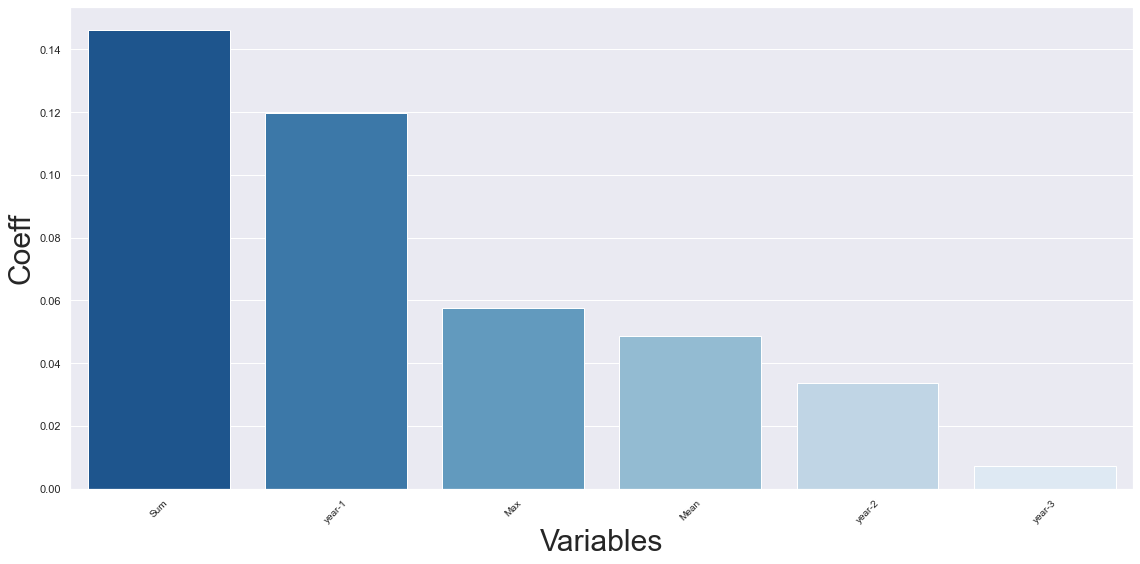

In [35]:
# let's now visualize this
data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
data_to_plot.columns = ['Variables','Importance Coefficients']
data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )
data_to_plot = data_to_plot[0:10]

plt.figure(figsize=(16, 8))
sns.barplot(
    x='Variables', y='Importance Coefficients',
    data=data_to_plot, palette='Blues_r')
plt.xticks(
    range(len(data_to_plot)),
    data_to_plot['Variables'], rotation='45', size=10)
plt.xlabel('Variables', fontsize=30)
plt.ylabel('Coeff', fontsize=30)
plt.tight_layout()
plt.show()

In [41]:
#NFIRS + ACS model
mdl,features,X_test,y_test =train_model(fires,top10.loc[:,'2009':'2016'],ACS = ACS,nyears =4,resample = True)

minor class 173462, major class 173462
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Max', 'inc_pct_poverty',
       'age_pct_under25', 'age_pct_25_64', 'age_pct_over65',
       ...
       'house_val_200K_250K', 'house_val_250K_300K', 'house_val_300K_400K',
       'house_val_400K_500K', 'house_val_500K_750K', 'house_val_750K_1M',
       'house_val_1M_1.5M', 'house_val_1.5M_2M', 'house_val_more_2M', 'Class'],
      dtype='object', length=110)
Predicting 2013:
              precision    recall  f1-score   support

       False       0.73      0.80      0.76     34651
        True       0.78      0.71      0.74     34734

    accuracy                           0.75     69385
   macro avg       0.76      0.75      0.75     69385
weighted avg       0.76      0.75      0.75     69385

8.489794644532687
minor class 173430, major class 173430
Index(['year-3', 'year-2', 'year-1', 'Sum', 'Mean', 'Max', 'inc_pct_poverty',
       'age_pct_under25', 'age_pct_25_64', 'age_pct_over65',
       

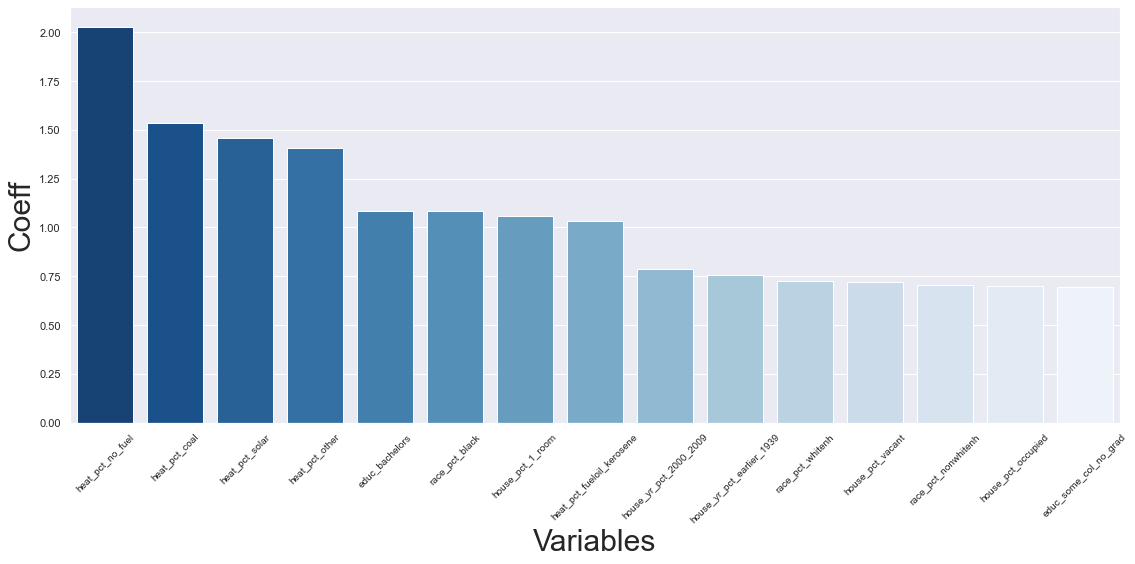

In [42]:
# let's now visualize this
data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
data_to_plot.columns = ['Variables','Importance Coefficients']
data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )
data_to_plot = data_to_plot[0:15]

plt.figure(figsize=(16, 8))
sns.barplot(
    x='Variables', y='Importance Coefficients',
    data=data_to_plot, palette='Blues_r')
plt.xticks(
    range(len(data_to_plot)),
    data_to_plot['Variables'], rotation='45', size=10)
plt.xlabel('Variables', fontsize=30)
plt.ylabel('Coeff', fontsize=30)
plt.tight_layout()
plt.show()

In [38]:
def process_data(X,y, test_size=0.2, seed=SEED):
    
    from scipy.stats import zscore
    
    
    X = np.log(X +1)
    y = np.log(y+1)
    
    print (X.shape)
   # rename features and add new features
    X.columns = ['year-{}'.format(year[0]+1) for year in enumerate(X.columns)]
    X.columns
    X['Sum'] = np.sum(X, axis = 1 )
    X['mean']= np.mean(X, axis = 1)
    X['median'] = np.median(x, axis = 1)
    
    
    X = zscore(X.astype(float), axis=0)
    
    
 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    return X_train, X_test, y_train, y_test

In [39]:
def plot_boundaries(X,y,model,n):
        
    from itertools import combinations
    n_elms = max(y.shape[0],1000) # only plot 1000 elements from each class
    
    n_cols = np.ceil(np.sqrt(n))
    n_rows = np.ceil(n / n_cols)

    names = X.columns
    combos = [c for c in combinations(range(X.shape[1]), 2) ]
    
    W = model.coef_[0]
        

    b = model.intercept_
    
    for c in enumerate(combos[:n]):
        x_idx = c[1][0]
        y_idx = c[1][1]
        plot_num = c[0]
            
            
        print('subplot{} {}: {}'.format(n_rows,n_cols,c[0]))
        plt.subplot(n_rows,n_cols,c[0]+1)
        plt.scatter(X.iloc[:n_elms, x_idx],
                    X.iloc[:n_elms, y_idx],
                    c=y[:n_elms], edgecolors='k',
                    alpha = .3, cmap=plt.cm.binary)
        
        ax = plt.gca()

        x_values = np.array(ax.get_xlim())
        y_values = -(b + np.dot(W[x_idx],x_values)) / W[y_idx]

        plt.plot(x_values, y_values )


        plt.xticks(())
        plt.xlabel(names[x_idx])
        plt.yticks(())
        plt.ylabel(names[y_idx])
    plt.show()

    
    
    
    
    
    
    

In [ ]:
plot_boundaries(X_test,y_test,mdl,16)

In [3]:
x = np.random.multivariate_normal([0,0,0,0],np.identity(4),1000)
x[0:500,2] += 5
x[0:500,3] -= 5
x[:500,1] += -1
x[:500,0] -= 10
y = np.zeros([1000,])
y[:500] = 1 
from sklearn.linear_model import LogisticRegression

tmdl = LogisticRegression().fit(x,y)

x =pd.DataFrame(data = x,columns={'0','1','2','3'})

NameError: name 'np' is not defined

In [4]:
plot_boundaries(x,y,tmdl,12)

NameError: name 'x' is not defined

In [5]:
 from itertools import combinations
c= [c for c in combinations(range(5),2)]

for a in enumerate(c[:5]):
    print(a[0],a[1], a[1][0],a[1][1])

0 (0, 1) 0 1
1 (0, 2) 0 2
2 (0, 3) 0 3
3 (0, 4) 0 4
4 (1, 2) 1 2


In [26]:
def fit_clf_model(data, model='LogisticRegression', seed=0, verbose=True, variables=None):
    _allowed_models = ["LogisticRegression", "SVM", "Tree", "RandomForest"]
    assert model in _allowed_models, "Invalid model name entered. Allowed options: %s" % _allowed_models

    X_train, X_test, y_train, y_test = process_data(data, variables)

    if verbose:
        print('-' * 90)
        print('[PROGRESS] Training %s classifier...' % model)
    
    if model == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(
            solver='lbfgs', max_iter=1000,
            random_state=seed,
        ).fit(X_train, y_train)

    elif model == 'SVM':
        from sklearn.svm import SVC
        clf = SVC(
            gamma='auto',
            kernel='linear',
            random_state=seed,
        ).fit(X_train, y_train)
    
    elif model == 'Tree':
        from sklearn import tree
        clf = tree.DecisionTreeClassifier(
            random_state=seed,
        ).fit(X_train,y_train)
        
    elif model == 'RandomForest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ).fit(X_train,y_train)
    else:
        raise(NotImplemented)

    if verbose:
        print('[PROGRESS] ...done!')
        msg = "\n[INFO] Train accuracy: {0:.1f} %,    Test accuracy: {1:.1f} %".format(
            clf.score(X_train, y_train) * 100, clf.score(X_test, y_test) * 100)
        print(msg)
        print('-' * 90)
        print('\n')
    
    return clf